In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb

%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [3]:
def gini(solution, submission):
    df = zip(solution, submission)
    df = sorted(df, key=lambda x: (x[1],x[0]), reverse=True)
    rand = [float(i+1)/float(len(df)) for i in range(len(df))]
    totalPos = float(sum([x[0] for x in df]))
    cumPosFound = [df[0][0]]
    for i in range(1,len(df)):
        cumPosFound.append(cumPosFound[len(cumPosFound)-1] + df[i][0])
    Lorentz = [float(x)/totalPos for x in cumPosFound]
    Gini = [Lorentz[i]-rand[i] for i in range(len(df))]
    return sum(Gini)

def normalized_gini(solution, submission):
    solution=np.array(solution)
    submission=np.array(submission)
    normalized_gini = gini(solution, submission)/gini(solution, solution)
    return normalized_gini

In [4]:
def xgboost_pred(train,labels,test):
    params = {}
    params["objective"] = "reg:linear"
    params["eta"] = 0.005
    params["min_child_weight"] = 6
    params["subsample"] = 0.7
    params["colsample_bytree"] = 0.7
    params["scale_pos_weight"] = 1
    params["silent"] = 1
    params["max_depth"] = 9
    params["max_delta_step"] = 5


    plst = list(params.items())

    #Using 5000 rows for early stopping. 
    offset = 4000

    num_rounds = 10000
    xgtest = xgb.DMatrix(test)

    #create a train and validation dmatrices 
    xgtrain = xgb.DMatrix(train[offset:,:], label=labels[offset:])
    xgval = xgb.DMatrix(train[:offset,:], label=labels[:offset])

    #train using early stopping and predict
    watchlist = [(xgtrain, 'train'),(xgval, 'val')]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=120)
    preds1 = model.predict(xgtest,ntree_limit=model.best_iteration)

    importance_matrix = xgb.importance(names, model = bst)

    #reverse train and labels and use different 5k for early stopping. 
    # this adds very little to the score but it is an option if you are concerned about using all the data. 
    train = train[::-1,:]
    labels = np.log(labels[::-1])

    xgtrain = xgb.DMatrix(train[offset:,:], label=labels[offset:])
    xgval = xgb.DMatrix(train[:offset,:], label=labels[:offset])

    watchlist = [(xgtrain, 'train'),(xgval, 'val')]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=120)
    preds2 = model.predict(xgtest,ntree_limit=model.best_iteration)

    print "Normalized gini is: {0}".format(normalized_gini(labels, model.predict(xgb.DMatrix(train))))
    #since the metric only cares about relative rank we don't need to average
    preds = (preds1)*1.4 + (preds2)*8.6
    return preds

In [5]:
#load train and test 
train  = pd.read_csv('../data/train.csv', index_col=0)
test  = pd.read_csv('../data/test.csv', index_col=0)


labels = train.Hazard
train.drop('Hazard', axis=1, inplace=True)

train_s = train
test_s = test


train_s.drop('T2_V10', axis=1, inplace=True)
train_s.drop('T2_V7', axis=1, inplace=True)
train_s.drop('T1_V13', axis=1, inplace=True)
train_s.drop('T1_V10', axis=1, inplace=True)

test_s.drop('T2_V10', axis=1, inplace=True)
test_s.drop('T2_V7', axis=1, inplace=True)
test_s.drop('T1_V13', axis=1, inplace=True)
test_s.drop('T1_V10', axis=1, inplace=True)

columns = train.columns
test_ind = test.index


train_s = np.array(train_s)
test_s = np.array(test_s)

# label encode the categorical variables
for i in range(train_s.shape[1]):
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_s[:,i]) + list(test_s[:,i]))
    train_s[:,i] = lbl.transform(train_s[:,i])
    test_s[:,i] = lbl.transform(test_s[:,i])

train_s = train_s.astype(float)
test_s = test_s.astype(float)


preds1 = xgboost_pred(train_s,labels,test_s)

#model_2 building

train = train.T.to_dict().values()
test = test.T.to_dict().values()

vec = DictVectorizer()
train = vec.fit_transform(train)
test = vec.transform(test)

preds2 = xgboost_pred(train,labels,test)

preds = 0.47 * (preds1**0.2) + 0.53 * (preds2**0.8)

#generate solution
preds = pd.DataFrame({"Id": test_ind, "Hazard": preds})
preds = preds.set_index('Id')
preds.to_csv('xgboost_benchmark.csv')

Will train until val error hasn't decreased in 120 rounds.
[0]	train-rmse:5.337972	val-rmse:5.285123
[1]	train-rmse:5.325962	val-rmse:5.273368
[2]	train-rmse:5.314110	val-rmse:5.261702
[3]	train-rmse:5.302120	val-rmse:5.249981
[4]	train-rmse:5.290180	val-rmse:5.238334
[5]	train-rmse:5.278403	val-rmse:5.226718
[6]	train-rmse:5.266706	val-rmse:5.215176
[7]	train-rmse:5.254884	val-rmse:5.203777
[8]	train-rmse:5.243445	val-rmse:5.192560
[9]	train-rmse:5.231988	val-rmse:5.181368
[10]	train-rmse:5.220570	val-rmse:5.170167
[11]	train-rmse:5.209190	val-rmse:5.159059
[12]	train-rmse:5.197910	val-rmse:5.148196
[13]	train-rmse:5.186651	val-rmse:5.137427
[14]	train-rmse:5.175594	val-rmse:5.126754
[15]	train-rmse:5.164405	val-rmse:5.115856
[16]	train-rmse:5.153566	val-rmse:5.105253
[17]	train-rmse:5.142741	val-rmse:5.094620
[18]	train-rmse:5.131973	val-rmse:5.084086
[19]	train-rmse:5.121266	val-rmse:5.073629
[20]	train-rmse:5.110594	val-rmse:5.063295
[21]	train-rmse:5.099954	val-rmse:5.053041
[22]	

Normalized gini is: 0.661065525989
Normalized gini is: 0.629045831146


Stopping. Best iteration:
[1566]	train-rmse:0.734793	val-rmse:0.847318



NameError: name 'model' is not defined

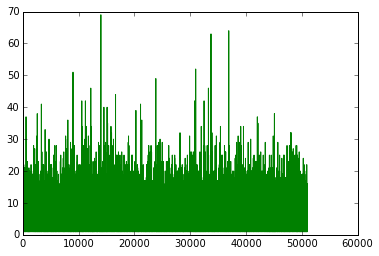

In [7]:
# Plot predicted and true interarrival times on the training set

plt.plot(labels, color="green", label="True value")
plt.plot(model.predict(xgb.DMatrix(train)), label="Predicted value")

plt.xlabel("Record number", fontsize=14)
plt.ylabel("Hazard rating", fontsize=14)
plt.legend(frameon=True, shadow=True, framealpha=0.7, loc=0, prop={"size": 14})

In [38]:
preds2

array([ 11.23742199,  20.05259514,  24.10741234, ...,  16.0765686 ,
        11.71094418,  13.0783205 ], dtype=float32)

In [24]:
train  = pd.read_csv('../data/train.csv', index_col=0)
labels = train.Hazard

In [34]:
labels.tolist()

[1,
 4,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 7,
 15,
 1,
 4,
 14,
 1,
 1,
 1,
 4,
 1,
 4,
 4,
 8,
 16,
 5,
 1,
 6,
 7,
 1,
 1,
 1,
 7,
 5,
 1,
 6,
 4,
 1,
 1,
 8,
 1,
 1,
 4,
 7,
 5,
 1,
 4,
 4,
 4,
 1,
 1,
 6,
 8,
 6,
 4,
 1,
 6,
 11,
 1,
 7,
 3,
 13,
 1,
 1,
 5,
 2,
 1,
 4,
 1,
 1,
 1,
 4,
 5,
 3,
 7,
 4,
 2,
 1,
 4,
 1,
 7,
 6,
 2,
 1,
 1,
 11,
 4,
 7,
 1,
 2,
 7,
 1,
 1,
 18,
 1,
 1,
 8,
 10,
 4,
 4,
 2,
 2,
 11,
 8,
 1,
 1,
 1,
 1,
 3,
 2,
 11,
 1,
 6,
 1,
 1,
 4,
 8,
 17,
 8,
 1,
 1,
 1,
 2,
 2,
 1,
 4,
 2,
 2,
 8,
 1,
 4,
 3,
 7,
 2,
 2,
 1,
 7,
 1,
 2,
 1,
 1,
 2,
 7,
 1,
 4,
 8,
 18,
 6,
 4,
 2,
 1,
 10,
 2,
 1,
 4,
 4,
 4,
 13,
 8,
 18,
 1,
 4,
 2,
 7,
 1,
 4,
 2,
 2,
 5,
 5,
 1,
 3,
 1,
 1,
 22,
 2,
 4,
 8,
 2,
 7,
 1,
 5,
 5,
 1,
 4,
 4,
 1,
 1,
 5,
 8,
 7,
 5,
 1,
 4,
 2,
 10,
 2,
 4,
 4,
 1,
 4,
 2,
 8,
 1,
 1,
 1,
 2,
 7,
 4,
 1,
 1,
 1,
 9,
 1,
 1,
 1,
 1,
 4,
 4,
 4,
 10,
 1,
 1,
 1,
 1,
 1,
 2,
 6,
 3,
 4,
 8,
 16,
 10,
 1,
 6,
 13,
 11,
 1,
 10,
 2,
 1,
 2,
 1,
 5,
 5,
 

In [36]:
normalized_gini(labels, preds["Hazard"].tolist())

-0.00642133875624984

In [35]:
test_ind

Int64Index([     6,      7,      8,      9,     10,     11,     13,     14,
                16,     17, 
            ...
            101977, 101979, 101982, 101983, 101985, 101989, 101990, 101995,
            101996, 101997],
           dtype='int64', name=u'Id', length=51000)